In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import grad, jit, jacobian, vmap

import scipy.linalg as sl
import scipy.integrate as si
import scipy.optimize
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
import numpy.linalg as nl

In [2]:
# size of spatial domain
a = 16

# spatial grid for the purposes of plotting
xvec = np.linspace(-a, a, 1025)

# our Fourier representation will use basis functions from n = -nmax to n = nmax
nmax = 256
# convert basis coefficients into wavefunction on grid by matrix multiplication
nvec = np.arange(-nmax,nmax+1)
convmat = np.exp(1j*np.pi*np.outer(nvec, xvec)/a)/np.sqrt(2*a)

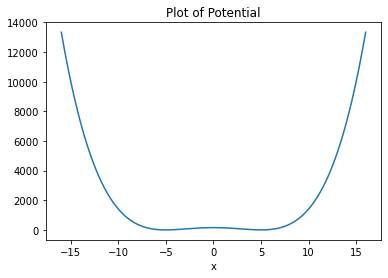

In [3]:
# symmetric double well potential just for fun
def v(x):
    return 0.25*(x**2 - 25)**2

# plot true potential
plt.plot(xvec, v(xvec))
plt.title('Plot of Potential')
plt.xlabel('x')
plt.show()

In [4]:
# some sampling and FFT tricks
# this integer '100' can be adjusted to improve resolution
# if we set f_sample = 2*nmax, then we are sampling at the Nyquist frequency
f_sample = 100 * 2 * nmax
t, dt = np.linspace(-a, a, f_sample+2, endpoint=False, retstep=True)
y = (np.fft.rfft(v(t)) / t.size)[:(2*nmax+1)]

# this stores the Fourier series coefficients for n-m=0 to n-m=2*nmax
vrow = y * (-1)**np.arange(2*nmax+1)
# create potential operator matrix using Toeplitz matrix function
vmat = sl.toeplitz(r=vrow,c=np.conj(vrow))

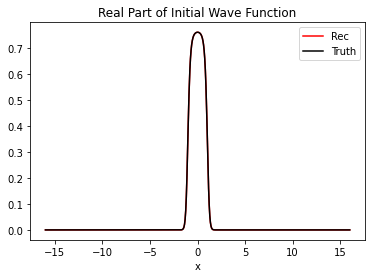

Rel Norm Diff: 4.039896186106999e-09


In [5]:
# rounded box function
def psi0(x):
    return (1.0 + np.tanh((1 - x**2)/0.5))/2.58046

vraw = np.zeros(nmax+1, dtype=np.complex128)
for thisn in range(nmax+1):
    def integ(x):
        return (2*a)**(-0.5)*np.exp(-1j*np.pi*thisn*x/a)*psi0(x)
    def rinteg(x):
        return np.real(integ(x))
    def iinteg(x):
        return np.imag(integ(x))
    vraw[thisn] = si.quad(rinteg, a=-a, b=a)[0] + 1j*si.quad(iinteg, a=-a, b=a)[0]

ainit = np.concatenate([np.conjugate(np.flipud(vraw[1:])), vraw])

# plot the real part of the normalized psi0
plt.plot(xvec, (ainit@convmat).real, 'r', label="Rec")
plt.plot(xvec, psi0(xvec).real, 'k', label="Truth")
plt.title('Real Part of Initial Wave Function')
plt.xlabel('x')
plt.legend()
plt.show()

print('Rel Norm Diff:', nl.norm(psi0(xvec) - ainit@convmat) / nl.norm(psi0(xvec)))

In [6]:
# kinetic matrix
kmat = np.diag( np.arange(-nmax,nmax+1)**2 * np.pi**2 / (2*a**2) )

# Hamiltonian matrix
hmat = kmat + vmat

# check whether Hamiltonian is Hermitian
print(np.linalg.norm( hmat - np.conj(hmat.T) ))

# eigendecomposition
spec, states = np.linalg.eigh(hmat)

# check whether this diagonalizes hmat
# note that if this is close to zero it means that
# hmat = states @ np.diag(spec) @ np.conj(states).T
print(np.linalg.norm( hmat @ states - states @ np.diag(spec) ))

# check whether we have a unitary matrix
print(np.linalg.norm( states @ np.conj(states).T - np.eye(2*nmax+1) ))

0.0
2.2695276922777366e-10
6.587061893801753e-14


In [7]:
# find indices that sort eigenvalues
ordering = np.argsort(spec)



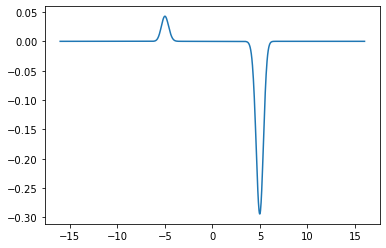

1.0
1.0


In [8]:
# pick out and plot ground state
groundstate = ordering[0]
wavefn = states[:,groundstate] @ convmat
plt.plot(xvec, -np.real(wavefn))
plt.show()

# check normalization
print(np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])))
print(si.trapezoid(np.abs(wavefn)**2, xvec))

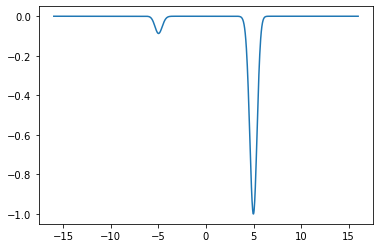

0.999999999999999
0.999999999999999


In [9]:
# pick out and plot j-th state with j starting at 0
wavefn = states[:,ordering[1]] @ convmat
plt.plot(xvec, np.imag(wavefn))
plt.show()

# check normalization
print(np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])))
print(si.trapezoid(np.abs(wavefn)**2, xvec))

In [10]:
# # set the time step and compute the propagator matrix
# # note that we are reusing the spec, states eigendecomposition of hmat computed above
dt = 0.01
prop = states @ np.diag(np.exp(-1j*spec*dt)) @ np.conj(states.T)

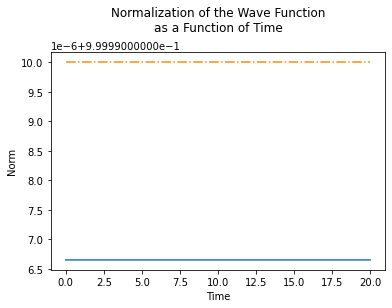

Average Norm of Trajectory (should be close to 1):
0.9999966495232524


In [11]:
# propagate the "a" vector of coefficients as defined above
nsteps = 2000
amat = np.zeros((nsteps+1, 2*nmax+1), dtype=np.complex128)
amat[0,:] = np.copy(ainit)
for j in range(nsteps):
    amat[j+1,:] = prop @ amat[j,:]

# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
psimatnormvec = si.trapezoid(np.abs(amat @ convmat) ** 2, xvec, axis=1)
plt.plot(np.arange(nsteps + 1) * dt, psimatnormvec)
plt.hlines(1 , 0, nsteps * dt, linestyles='-.', colors='darkorange')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory (should be close to 1):', psimatnormvec.sum() / (nsteps + 1), sep='\n')

In [12]:
m = 2*nmax+1
n = 2*nmax+1
a = np.array((-1)*np.arange(0,m)).reshape(m,1) 
b = np.array([np.arange(m-1,m+n-1 ),])
indx = jnp.array(a + b)

In [13]:
# goal: make a JAX-compliant version

def adjhelper(x):
    m = 2*nmax + 1
    thetahatR = x[:m]
    thetahatI = jnp.concatenate([jnp.array([0.0]), x[m:]])
    thetahat = thetahatR + 1j*thetahatI
    
    w = jnp.concatenate([jnp.flipud(jnp.conj(thetahat)), thetahat[1:]])
    vhatmat = w[indx]
    
    # Hamiltonian matrix 
    hhatmat = kmat + vhatmat
    
    # eigendecomposition and compute propagator
    hatspec, hatstates = jnp.linalg.eigh(hhatmat)
    hatprop = hatstates @ jnp.diag(jnp.exp(-1j*hatspec*dt)) @ jnp.conj(hatstates.T)
    hatpropH = hatstates @ jnp.diag(jnp.exp(1j*hatspec*dt)) @ jnp.conj(hatstates.T)
    
    # propagate the "a" vector of coefficients forward in time
    # in other words, solve the *forward* problem
    ahatmat = [jnp.array(ainit)]
    for j in range(nsteps):
        ahatmat.append( hatprop @ ahatmat[j] )
    
    ahatmat = jnp.stack(ahatmat)
    
    # propagate the "lambda" vector of coefficients backward in time
    # in other words, solve the *adjoint* problem
    lambmat = [ahatmat[nsteps,:] - amat[nsteps,:]]
    
    itr = 0
    for j in range(nsteps-1,-1,-1):
        lambmat.append( ahatmat[j,:] - amat[j,:] + hatpropH @ lambmat[itr] )
        itr += 1
        
    lambmat = jnp.flipud( jnp.stack(lambmat) )    
    
    # Compute the gradients
    # Most of this stuff is math that computes the directional derivative of the matrix exponential,
    # the part of the derivation above where we see "\partial \exp(Z) / \partial Z \cdot A"
    # for some matrix A.
    # All of this code has been checked against JAX autograd to make sure it is computing gradients correctly.
    # Note that it is faster than JAX autograd at present

    offdiagmask = jnp.ones((m, m)) - jnp.eye(m)
    expspec = jnp.exp(-1j*dt*hatspec)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(hatspec, hatspec)
    denom = offdiagmask * (-1j*dt)*(s1 - s2) + jnp.eye(m)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)
    myeye = jnp.eye(m)
    ws = jnp.hstack([jnp.fliplr(myeye), myeye[:,1:]]).T
    ctrmats = ws[indx]
    derivamats = jnp.einsum('ij,jkm,kl->ilm',hatstates.conj().T,ctrmats,hatstates) * jnp.expand_dims(mask,2)
    alldmatreal = -1j*dt*jnp.einsum('ij,jkm,kl->mil',hatstates,derivamats,hatstates.conj().T)
    
    ws = 1.0j*jnp.hstack([-jnp.fliplr(myeye), myeye[:,1:]])
    ws = ws[1:,:]
    ws = ws.T
    ctrmats = ws[indx]
    derivamats = jnp.einsum('ij,jkm,kl->ilm',hatstates.conj().T,ctrmats,hatstates) * jnp.expand_dims(mask,2)
    alldmatimag = -1j*dt*jnp.einsum('ij,jkm,kl->mil',hatstates,derivamats,hatstates.conj().T)
    
    alldmat = jnp.vstack([alldmatreal, alldmatimag])
    
    return lambmat, alldmat, ahatmat

In [14]:
def justobj(x):
    m = 2*nmax + 1

    # this code is used when the model of the potential is
    # the coefficients of the Fourier basis representation
    thetahatR = x[:m]
    thetahatI = jnp.concatenate([jnp.array([0.0]), x[m:]])
    thetahat = thetahatR + 1j*thetahatI
    
    # hardcoded Toeplitz so that autodiff doesn't complain
    w = jnp.concatenate([jnp.flipud(jnp.conj(thetahat)), thetahat[1:]])
    vhatmat = w[indx]
    
    # Hamiltonian matrix 
    hhatmat = kmat + vhatmat
    
    # eigendecomposition and compute propagator
    hatspec, hatstates = jnp.linalg.eigh(hhatmat)
    hatprop = hatstates @ jnp.diag(jnp.exp(-1j*hatspec*dt)) @ jnp.conj(hatstates.T)
    
    # propagate the "a" vector of coefficients as defined above
    ahatmat = [ainit]
    for j in range(nsteps):
        ahatmat.append(hatprop @ ahatmat[j])
    
    ahatmat = jnp.stack(ahatmat)
    
    # compute only the objective function
    resid = ahatmat - amat
    obj = 0.5 * jnp.sum(resid.conj() * resid).real
    
    return obj

def justgrad(x):
    lambmat, alldmat, ahatmat = adjhelper(x)    
    # compute all entries of the gradient at once
    gradients = jnp.real(jnp.einsum('ij,ajk,ik->a', jnp.conj(lambmat[1:,:]), alldmat, ahatmat[:-1,:]))
    return gradients

In [17]:
truethetaR = jnp.real(vrow)
truethetaI = jnp.imag(vrow[1:])
x0 = jnp.concatenate([truethetaR, truethetaI])
print(x0.shape)

(1025,)


In [18]:
justobj(x0)

DeviceArray(1.95688707e-20, dtype=float64)

In [19]:
jjustgrad = jit(justgrad)

In [20]:
mygrad = jjustgrad(x0)

In [21]:
jaxgrad = jit(grad(justobj))

In [22]:
jgrad = jaxgrad(x0)

In [23]:
np.linalg.norm(mygrad - jgrad)

1.3602594284189946e-09

In [24]:
for i in range(100):
    randx = np.random.normal(size=4*nmax+1)*10
    t1 = time.time()
    mygrad = jjustgrad(randx)
    t2 = time.time()
    jgrad = jaxgrad(randx)
    t3 = time.time()
    print( "adj time = " + str(t2-t1) )
    print( "jax time = " + str(t3-t2) )
    print( "error = " + str(np.linalg.norm(mygrad - jgrad)) )
    

adj time = 0.15276861190795898
jax time = 0.4893219470977783
error = 8.61166455812075e-09
adj time = 0.11443901062011719
jax time = 0.4851105213165283
error = 4.531054705514309e-09
adj time = 0.13343453407287598
jax time = 0.47075438499450684
error = 3.83817940821155e-09
adj time = 0.13309574127197266
jax time = 0.48103952407836914
error = 4.348353122862224e-09
adj time = 0.1818690299987793
jax time = 0.5234296321868896
error = 3.0970515971726717e-09
adj time = 0.16447663307189941
jax time = 0.4754512310028076
error = 3.577639859815486e-09
adj time = 0.13281989097595215
jax time = 0.48296046257019043
error = 1.644366335943686e-08
adj time = 0.13592839241027832
jax time = 0.48032665252685547
error = 3.371851791106654e-09
adj time = 0.13852453231811523
jax time = 0.524193286895752
error = 3.858342134345822e-09
adj time = 0.1854722499847412
jax time = 0.4748539924621582
error = 5.055379153047865e-09
adj time = 0.14766907691955566
jax time = 0.4549446105957031
error = 6.274772006587352e-09